In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
def fetch_btc_eth_data():
    data=yf.download('BTC-ETH',start='2023-01-01')['Close']
    data.columns =[col[0] if isinstance(col, tuple) else col for col in data.columns]
    data=data.rename(columns={'BTC-ETH':'BTC_ETH'})
    data['Spread_Mean']=data['BTC_ETH'].rolling(window=30).mean()
    data['Spead_Std']=data['BTC_ETH'].rolling(window=30).std()
    data['Upper_Band']=data['Spread_Mean']+1*data['Spead_Std']
    data['Lower_band']=data['Spread_Mean']-1*data['Spead_Std']
    data.dropna(inplace=True)
    return data
data=fetch_btc_eth_data()
data

C:\Users\user\AppData\Local\Temp\ipykernel_1224\1582737967.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download('BTC-ETH',start='2023-01-01')['Close']
[*********************100%***********************]  1 of 1 completed


,BTC_ETH,Spread_Mean,Spead_Std,Upper_Band,Lower_band
Date,,,,,
2023-01-30,14.572675,13.747971,0.490474,14.238445,13.257496
2023-01-31,14.584789,13.772693,0.513583,14.286277,13.259110
2023-02-01,14.449918,13.796382,0.528170,14.324552,13.268212
2023-02-02,14.283883,13.814819,0.535405,14.350224,13.279414
2023-02-03,14.085829,13.836996,0.532279,14.369276,13.304717
...,...,...,...,...,...
2025-08-02,33.164791,35.954055,4.625498,40.579553,31.328556
2025-08-03,32.658981,35.632216,4.501958,40.134174,31.130258
2025-08-04,30.930424,35.227617,4.353596,39.581212,30.874021


In [3]:
def pair_trading_backtest_mtm(data,initial_balance=1):
    balance_eth=initial_balance
    btc_holdings=0
    in_btc=False
    trade_log=[]

    for i in range(len(data)):
        date=data.index[i]
        ratio=data['BTC_ETH'].iloc[i]
        upper_band=data['Upper_Band'].iloc[i]
        lower_band=data['Lower_band'].iloc[i]

        if ratio<lower_band and not in_btc:
            btc_holdings=balance_eth/ratio
            in_btc=True
            trade_log.append({
                'Date':date,
                'Action':'Buy_BTC',
                'Ratio':ratio,
                'BTC_Holdings':btc_holdings,
                'ETH_balance':balance_eth
            })
            
        elif ratio >upper_band and in_btc:
            balance_eth=btc_holdings*ratio
            btc_holdings=0
            in_btc=False
            trade_log.append({
                'Date':date,
                'Action':'Sell_BTC',
                'Ratio': ratio,
                'BTC_Holdings':btc_holdings,
                'ETH_balance':balance_eth
            })

    if in_btc:
        final_ratio=data['BTC_ETH'].iloc[-1]
        balance_eth=btc_holdings*final_ratio
        trade_log.append({
            'Date':data.index[-1],
            'Action':'Market_To_Market',
            'Ratio': final_ratio,
            'BTC_holdings':0,
            'ETH_balance': balance_eth
        })
    trade_log=pd.DataFrame(trade_log)
    trade_log.set_index('Date', inplace=True)
    return balance_eth,trade_log

final_balance_eth,trade_log=pair_trading_backtest_mtm(data)
print(f"Final ETH Balance: {final_balance_eth:.4f} ETH")
print(trade_log)

Final ETH Balance: 1.3646 ETH
                      Action      Ratio  BTC_Holdings  ETH_balance  \
Date                                                                 
2023-03-08           Buy_BTC  14.156995      0.070636     1.000000   
2023-03-16          Sell_BTC  14.716833      0.000000     1.039545   
2023-04-15           Buy_BTC  14.505835      0.071664     1.039545   
2023-05-01          Sell_BTC  15.661056      0.000000     1.122333   
2023-05-22           Buy_BTC  14.823363      0.075714     1.122333   
2023-06-14          Sell_BTC  14.902243      0.000000     1.128305   
2023-07-19           Buy_BTC  15.732220      0.071719     1.128305   
2023-08-09          Sell_BTC  16.039349      0.000000     1.150332   
2023-08-19           Buy_BTC  15.684526      0.073342     1.150332   
2023-08-30          Sell_BTC  16.030392      0.000000     1.175698   
2023-11-10           Buy_BTC  17.299368      0.067962     1.175698   
2023-12-05          Sell_BTC  18.715279      0.000000     1.

In [4]:
def plot_pair_trading(data,trade_log):
    plt.figure(figsize=(14,8))
    plt.plot(data.index,data['BTC_ETH'],label='BTC/ETH Ratio',color='Blue',alpha=0.7)
    plt.plot(data['Spread_Mean'],label='Spead Mean',linestyle='--',color='orange',alpha=0.7)
    plt.plot(data['Upper_Band'],label='Upper Band',linestyle='--',color='red',alpha=0.7)
    plt.plot(data['Lower_band'],label='Lower Band',linestyle='--',color='green',alpha=0.7)


    if not trade_log.empty:
        buy_points=trade_log[trade_log['Action']=='Buy_BTC']
        sell_points=trade_log[trade_log['Action']=='Sell_BTC']
        
        print(buy_points.index)
        #print(sell_points.index)

        plt.scatter(data.loc[trade_log[trade_log['Action']=='Buy_BTC'].index].index,data.loc[trade_log[trade_log['Action']=='Buy_BTC'].index].BTC_ETH,color='green',label='Buy Signal',zorder=5)
        plt.scatter(data.loc[trade_log[trade_log['Action']=='Sell_BTC'].index].index,data.loc[trade_log[trade_log['Action']=='Sell_BTC'].index].BTC_ETH,color='red',label='Sell Signal',zorder=5)

        plt.legend()
        plt.title('BTC/ETH Pair Trading Strategy')
        plt.xlabel('Date')
        plt.ylabel('BTC/ETH Ratio')
        plt.show()
        

DatetimeIndex(['2023-03-08', '2023-04-15', '2023-05-22', '2023-07-19',
               '2023-08-19', '2023-11-10', '2023-12-28', '2024-01-11',
               '2024-02-20', '2024-04-28', '2024-05-21', '2024-11-10',
               '2024-11-28', '2025-05-09', '2025-07-10'],
              dtype='datetime64[ns]', name='Date', freq=None)


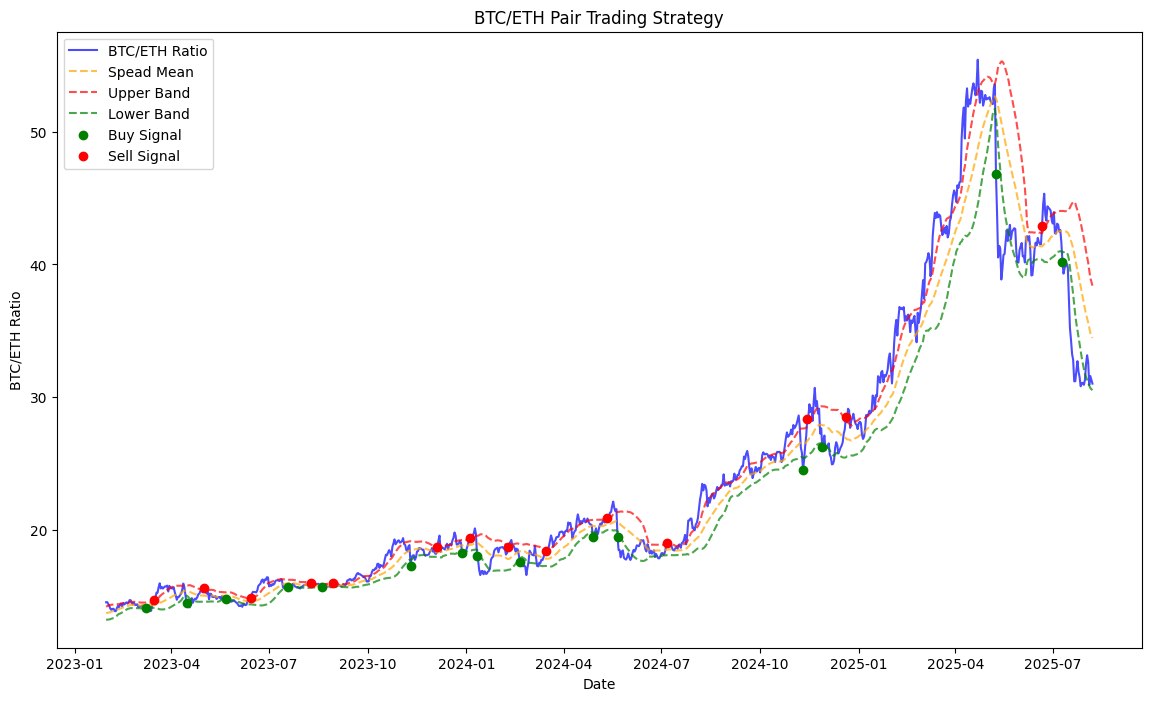

In [5]:
plot_pair_trading(data,trade_log)